# Predicting when a poem was written by it's style and word usage.

One of the best things about data science is its versatility. You can do a data science project on just about anything. For this project I decided to see if a machine learning model can identify the era in which a poem was written by its word choice and frequency. If the era can be predicted, with what kind of accuracy? Also, are some eras more identifiable by style than others. These were the questions I sought to answer with this project. 

The model was able to differentiate between the different time periods and predict the poem's class with an 81% accuracy overall, with varying degrees of accuracy for specific classes. Going forward, I intend to engineer additional stylistic features related to word choice and frequency to make the model even more robust. 
#### Getting Data:
The first step this project required was data collection. It's really nice to be handed a clean data set for a project, but life doesn't always work that way. Data collection can be quite challenging, but can also be quite fun. After searching fruitlessly for a corpus of poetry in a digital text format, there was no choice but to explore other options. Enter webscraping, a cool, fun, and exciting way to collect data. Webscraping is the process of pulling information from web pages, which often contain all their text in the HTML code which dictates the website's structure. Python, the language that I used for all of this analysis, has some packages that enable efficient webscraping. The code for my webscraper is available in the notebook entitled 'Webscraper'.
#### Data Cleaning:
A large portion of this project involved the data cleaning process. For example, since I scraped the data from a website, I first had to remove all the HTML tags and ensure that doing that didn't push the lines of the poem together, which would cause some word loss. 

When analyzing text, a lot of preprocessing is necessary. A computer doesn't read text the way we do, so it would treat 'Cookies' and 'cookies' as two different words. Generally, we convert all our entries to lowercase so that the computer can recognize them. I also had to remove all the punctuation and numbers. 
#### Classes:
I settled on three different eras to model, the 18th, 19th, and 20th centuries. These are arbitrary boundaries that mean something to us, but I was curious to discover if there is a significant difference in poetry style on each side of these boundaries. 
#### Feature Creation and Modeling:
There are a few different approaches for creating features from text. I used the most common one, a Count Vectorizer. This approach, sometimes called a 'bag of words,' creates a separate feature for each word that appears in the data set. Then, for each poem, it assigns a '1' to words that the poem contains, and a '0' to words that it doesn't. There are more complex approaches, but a simple Count Vectorizer worked best for my data. That makes sense, because a simple count of word usage and frequency may give a better representation of text style than more complex methods that aren't looking for style as much as content. 

I used a Multinomial Naive Bayes model to distinguish between and predict the classes. This model treats all the features as having a multinomial distribution and assumes independence of all the features. I ran many other models as well, and the Multinomial Naive Bayes consistently performed the best. This model comes with a great feature which returns the log probability of each feature belonging to each class. This gives us some insight into which words are most related to which classes. 
#### Results:
The model performed well, giving an overall accuracy score of 81%, which means the model accurately predicted the era of 81% of the observations it had not before seen. This demonstrates the efficacy of this type of modeling in general, as well as the answers the question central to this project. A computer **CAN** differentiate between different poetry styles and predict the era of poems. The model performed best on the 18th century, correctly identifying 91% of observations. It did not perform as well for the 19th and 20th centuries, with 72% and 81% accuracy scores, respectively. Immediately below is an image showing the percentages of true predictions for each class, and the percentages which were misclassified. Further below I will elaborate on the scores for each class and point out specific words that were strong indicators of a class. 

![confusion_matrix](confusion_matrix.png)

**Imports and reading in the file.**

In [1]:
import numpy as np
import pandas as pd
import string
import re
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier
import itertools
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
df = pd.read_csv('all_poets.csv', names=['old_index', 'poem', 'name'], header=0)
df.head(2)

IOError: File all_poets.csv does not exist

In [4]:
df.drop('old_index', axis=1, inplace=True)
df.head(2)

,poem,name
0,"<div style=""padding-left:14px;padding-top:20px...",by Rebecca Elson
1,"<div style=""padding-left:14px;padding-top:20px...",by Rebecca Elson


**Data cleaning commences!**  

Each poem is still wrapped in the HTML tags from its web page. The BeautifulSoup library has a function to select the text from page, but in this situation, that caused words to be joined together. I elected to clean the data myself with Python. It was a lengthier process, but one that I felt worthwhile given the importance of each word. 

In [5]:
df.name = df.name.apply(lambda x: x.replace('by ', ''))
df.head(3)

,poem,name
0,"<div style=""padding-left:14px;padding-top:20px...",Rebecca Elson
1,"<div style=""padding-left:14px;padding-top:20px...",Rebecca Elson
2,"<div style=""padding-left:14px;padding-top:20px...",James Thomson


In [6]:
df.poem = df.poem.apply(lambda x: x.split('<br/>'))
df.head(2)

,poem,name
0,"[<div style=""padding-left:14px;padding-top:20p...",Rebecca Elson
1,"[<div style=""padding-left:14px;padding-top:20p...",Rebecca Elson


In [7]:
df['last_line'] = [x[-1].split('\t')[0] for x in df.poem]
df['first_line'] = df.poem.apply(lambda x: x[0].split('\t')[-1])
df.head(2)

,poem,name,last_line,first_line
0,"[<div style=""padding-left:14px;padding-top:20p...",Rebecca Elson,And only count things.,"We astronomers are nomads,"
1,"[<div style=""padding-left:14px;padding-top:20p...",Rebecca Elson,That leaves the nape hairs leaping.,Having picked the final datum


In [8]:
df.poem = df.poem.apply(lambda x: x[1:])
df.head(2)

,poem,name,last_line,first_line
0,"[Merchants, circus people,, All the earth our ...",Rebecca Elson,And only count things.,"We astronomers are nomads,"
1,"[From the universe, And fixed it in its column...",Rebecca Elson,That leaves the nape hairs leaping.,Having picked the final datum


In [9]:
df.poem = df.poem.apply(lambda x: x[0:-1])
df.head(2)

,poem,name,last_line,first_line
0,"[Merchants, circus people,, All the earth our ...",Rebecca Elson,And only count things.,"We astronomers are nomads,"
1,"[From the universe, And fixed it in its column...",Rebecca Elson,That leaves the nape hairs leaping.,Having picked the final datum


In [10]:
df.poem = df.poem.apply(lambda x: ' '.join(x))
df['full_poem'] = df.first_line + ' ' + df.poem + ' ' + df.last_line
df.full_poem[7]

'AS we rush, as we rush in the Train,     The trees and the houses go wheeling back,  But the starry heavens above the plain     Come flying on our track.   All the beautiful stars of the sky,     The silver doves of the forest of Night,  Over the dull earth swarm and fly,     Companions of our flight.   We will rush ever on without fear;     Let the goal be far, the flight be fleet!  For we carry the Heavens with us, dear,     While the Earth slips from our feet!'

In [11]:
df.rename(columns={'poem':'poem_body'}, inplace=True)
df.drop(['poem_body', 'last_line', 'first_line'], axis=1, inplace=True)
df.to_csv('poems-cleaned.csv', index=False)

In [12]:
df.head(2)

,name,full_poem
0,Rebecca Elson,"We astronomers are nomads, Merchants, circus p..."
1,Rebecca Elson,Having picked the final datum From the univers...


**Clean poems achieved!**

On to the years for each poet.

In [13]:
years = pd.read_csv('poets_years.csv')
years.head(2)

,name,number,years
0,Maya Angelou,18),1928 - present)
1,Margaret Atwood,28),1939 - present)


In [14]:
years = years.apply(lambda x: x.str.replace(')', ''))
years['birth'] = years.years.apply(lambda x: x.split('-')[0])
years['death'] = years.years.apply(lambda x: x.split('-')[-1])
years.drop('years', axis=1, inplace=True)
years.to_csv('years-cleaned.csv', index=False)
years.head(3)

,name,number,birth,death
0,Maya Angelou,18,1928,present
1,Margaret Atwood,28,1939,present
2,Matthew Arnold,45,1822,1888


In [15]:
years.name = years.name.apply(lambda x: x.strip())
years.head(1)

,name,number,birth,death
0,Maya Angelou,18,1928,present


In [16]:
years[years.name == 'Vlanes']

,name,number,birth,death
425,Vlanes,Vladislav Nekliaev,13,13


In [17]:
years.iloc[425] = ['Vlanes', 13, '1969', ' present'] 
years.iloc[425]

name        Vlanes
number          13
birth         1969
death      present
Name: 425, dtype: object

In [18]:
years.number = years.number.astype(int)
years.birth = years.birth.astype(int)
years.death = [' 2016' if x == ' present' else x for x in years.death]
years.death = years.death.astype(int)
years.dtypes

name      object
number     int64
birth      int64
death      int64
dtype: object

In [19]:
full_df = df.merge(years, on='name')
full_df.to_csv('full_df.csv', index=False)

I now have a DataFrame with all the poems and their poets, with the years of birth and death for each poet. 

In [20]:
df = pd.read_csv('full_df.csv', names=['name', 'poem', 'num_poems', 'birth', 'death'], header=0)
df.head(2)

,name,poem,num_poems,birth,death
0,Rebecca Elson,"We astronomers are nomads, Merchants, circus p...",2,1960,1999
1,Rebecca Elson,Having picked the final datum From the univers...,2,1960,1999


In [21]:
print df.isnull().sum()
print '\n'
print df.dtypes
print '\n'
print df.shape

name         0
poem         0
num_poems    0
birth        0
death        0
dtype: int64


name         object
poem         object
num_poems     int64
birth         int64
death         int64
dtype: object


(34330, 5)


In [22]:
df = df[df.death > 1700]
df.shape

(32259, 5)

There are so many more poems from Raymond A. Foss than anyone else. I decided to drop him from the DataFrame entirely so his style doesn't effect the whole class. 

In [23]:
df.name.value_counts().head()

Raymond A. Foss           12138
Emily Dickinson            1779
Robert William Service      854
Robert Burns                579
Isaac Watts                 458
Name: name, dtype: int64

In [24]:
df = df[df.name != 'Raymond A. Foss']
len(df)

20121

In [25]:
df.reset_index(drop=True, inplace=True)
df.tail()

,name,poem,num_poems,birth,death
20116,Derek Walcott,After that hot gospeller has levelled all but ...,21,1930,2016
20117,Derek Walcott,"A wind is ruffling the tawny pelt Of Africa, K...",21,1930,2016
20118,Derek Walcott,"1 Adios, Carenage In idle August, while the ...",21,1930,2016
20119,Derek Walcott,"The time will come when, with elation you wi...",21,1930,2016
20120,Derek Walcott,There were still shards of an ancient pastoral...,21,1930,2016


There were a few hundred entries that contained only 'div' HTML tags. Those pages must have had a slightly different structure, causing the poems to get deleted when I cleaned them all. The code below is how I removed them.

In [26]:
for i in range(0, len(df)):
    if '<div' in df.poem.iloc[i]:
        df.set_value(i, 1, np.nan, takeable=True)

In [27]:
count = 0
for poem in df.poem:
    if '<div' in df.poem:
        count +=1
print count

0


In [28]:
df.isnull().sum()

name           0
poem         377
num_poems      0
birth          0
death          0
dtype: int64

In [29]:
df[df.isnull().any(axis=1)].head(2)

,name,poem,num_poems,birth,death
2394,Adrienne Rich,NaN,31,1929,2016
2395,Adrienne Rich,NaN,31,1929,2016


In [30]:
df.dropna(inplace=True)
df.isnull().sum()

name         0
poem         0
num_poems    0
birth        0
death        0
dtype: int64

In [31]:
df.shape

(19744, 5)

We have the clean poems and we have the poets years. Now, I convert all the poems to lowercase so the computer will treat all the words the same, and remove all the punctuation and digits.

In [32]:
df.head(2)

,name,poem,num_poems,birth,death
0,Rebecca Elson,"We astronomers are nomads, Merchants, circus p...",2,1960,1999
1,Rebecca Elson,Having picked the final datum From the univers...,2,1960,1999


In [33]:
df.poem = df.poem.apply(lambda x: x.lower())
df.poem = df.poem.apply(lambda x: x.translate(None, string.punctuation))
df.poem = df.poem.apply(lambda x: x.translate(None, string.digits))
df.poem  = [re.sub('[^A-Za-z ]+', '', x) for x in df.poem]
df.head()

,name,poem,num_poems,birth,death
0,Rebecca Elson,we astronomers are nomads merchants circus peo...,2,1960,1999
1,Rebecca Elson,having picked the final datum from the univers...,2,1960,1999
2,James Thomson,shall the great soul of newton quit this earth...,10,1700,1748
3,James Thomson,see winter comes to rule the varied year sull...,10,1700,1748
4,James Thomson,fareweel ye bughts an all your ewes an field...,10,1700,1748


The function below will return a class for each poem depending on the year of the poet's death. I was conflicted about how to break up the classes, and this is what I settled on for now. I intend to return and examine the question more rigorously to determine if there is a better way to break up the classes. As it stands, I created 3 classes based on the poet's death. The 18th, 19th, and 20th centuries. The 20th includes poets who are still living today. 

In [34]:
def epoch(df):
    if df['death'] < 1800:
        return 1
    elif (df['death'] >= 1800) & (df['death'] < 1900):
        return 2
    else:
        return 3
    
df['epoch'] = df.apply(epoch, axis=1)

In the cell below, I randomly selected poems from the classes that have more values in order to make my classes balanced. In the future, I would like to collect more data from the lesser represented classes. If that isn't possible, I will explore methods of sampling that are more robust than the simple slicing I've done. 

In [35]:
df_1 = df[df.death < 1800]
df_2 = df[(df.death >= 1800) & (df.death < 1900)][::4]
df_3 = df[(df.death >= 1900)][::9]
print df_1.shape
print df_2.shape
print df_3.shape

(1349, 6)
(1428, 6)
(1410, 6)


In [36]:
df_model = pd.concat([df_1, df_2, df_3], axis=0)
df_model.reset_index(inplace=True, drop=True)
df_model.to_csv('final_df.csv')
df_model.head()

,name,poem,num_poems,birth,death,epoch
0,James Thomson,shall the great soul of newton quit this earth...,10,1700,1748,1
1,James Thomson,see winter comes to rule the varied year sull...,10,1700,1748,1
2,James Thomson,fareweel ye bughts an all your ewes an field...,10,1700,1748,1
3,James Thomson,give a man a horse he can ride give a man ...,10,1700,1748,1
4,James Thomson,sweet ravelrig i neer could part from thee bu...,10,1700,1748,1


### Modeling:
This begins the modeling phase of the project. The data is clean, the classes are set. Now I get to answer my question: Can my computer tell the difference between the styles of different eras? I try many different types of models to determine which can classify my data best. 

I split the data into training and testing sets, so as to control for overfitting. I want a model that generalizes well to new data it hasn't seen before. One way to test that is the train-test-split. If the model performs well on my training data **and** my testing data, I know it works well on data it hasn't seen and isn't overfit to the training data.

I experimented with many models and with many of their different parameters, but surprisingly, the models performed best with the simplest, default parameters. This was most apparent with the Count Vectorizer, which creates a feature for each word present in the data set, and computes the word count for each word in each poem. In most projects dealing with text data, the practice is to take out a list of stop words, words that are common in speech and don't really teach us anything. Words like 'the' and 'his.' In this situation, taking out the stopwords actually hurt the performance of the model. After some thought, this made a lot of sense. This project is not about content, but about style. The frequency of words like 'the' is quite relevant when it comes to style.

The best performing model was the Multinomial Naive Bayes Classifier, which gave an overall accuracy score of .82. Below is a visualization of the confusion matrix, which breaks down the accuracy for each class. 

The model performs slightly worse when the stopwords are taken out, but I ran that anyway to get a list of the features that were likeliest to belong to each class that were more informative than frequencies of 'the' and 'his' and the 'like.'

In [37]:
X = df_model.poem
y = df_model.epoch

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [39]:
cvt = CountVectorizer()

In [40]:
X_train = pd.DataFrame(cvt.fit_transform(X_train).todense(), columns=cvt.get_feature_names())
X_test = pd.DataFrame(cvt.transform(X_test).todense(), columns=cvt.get_feature_names())
X_train.rename(columns={'fit':'fit_feature'}, inplace=True);
X_test.rename(columns={'fit':'fit_feature'}, inplace=True);

In [41]:
print X_train.shape
print y_train.shape
print X_test.shape
print y_test.shape

(2930, 42491)
(2930,)
(1257, 42491)
(1257,)


In [42]:
# ch2 = SelectKBest(chi2, k=11500)
# X_train_ch = ch2.fit_transform(X_train, y_train)
# X_test_ch = ch2.transform(X_test)

In [43]:
nb = MultinomialNB(alpha=0.3)
nb.fit(X_train, y_train)
preds = nb.predict(X_test)
nb.score(X_test, y_test)

0.81622911694510736

In [44]:
cross_val_score(nb, X_train, y_train, cv=10).mean()

0.80308683888317134

In [45]:
nb.feature_log_prob_.shape

(3, 42491)

In [46]:
log_prob = pd.DataFrame(nb.feature_log_prob_, columns=X_train.columns, index=['18th', '19th', '20th'])
prob = np.exp(log_prob)

In [47]:
eighteenth = prob.iloc[0].nlargest(11).to_frame().T
nineteenth = prob.iloc[1].nlargest(11).to_frame().T
twentieth = prob.iloc[2].nlargest(11).to_frame().T

These are the 11 words with the highest probability of belonging to each class. This demonstrates that the frequency of the words that are used most frequently have the largest effect on determining the class likelihood. At the bottom of the notebook, I have an analysis of the most likely words when stop words have been taken out. 

In [48]:
common_words = pd.concat([eighteenth, nineteenth, twentieth])
common_words

,and,for,he,his,in,is,my,of,that,the,to,with,you
18th,0.034161,0.008343,0.007394,0.012676,0.014522,NaN,0.011380,0.016792,0.007928,0.054860,0.020085,0.007683,NaN
19th,0.040298,0.007160,NaN,0.007339,0.015172,0.006922,0.008289,0.024131,0.009956,0.058348,0.019231,0.009339,NaN
20th,0.040866,0.007590,NaN,NaN,0.017082,0.007971,0.008317,0.026227,0.009779,0.066373,0.018959,0.009065,0.008022


In [49]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[ 0.91  0.04  0.05]
 [ 0.05  0.72  0.22]
 [ 0.    0.18  0.81]]


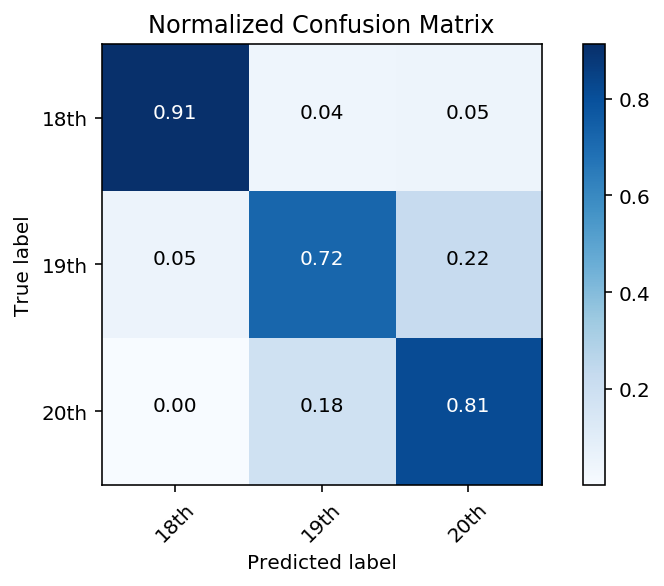

In [50]:
cnf_matrix = confusion_matrix(y_test, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['18th', '19th', '20th'], normalize=True,
                      title='Normalized Confusion Matrix')
plt.show()

In the image just above this cell, you can see that the model distinguishes 18th century poetry from the other classes best, with 91% accuracy. Interestingly, the model wrongly classified slightly more 18th century works as 20th century than as 19th. 

The model classified 19th century poetry worst of all the classes, though still reasonably well. It was 72% accurate, but misclassified 22% of the poems as 20th century, and a small number as 18th. 

The model performed quite well on 20th century works, correctly classifying 81%, and misclassifying 18% as 19th century. Interestingly, it did not mistake any 20th century poems as 18th century works. 

18th century poetry appears to be most distinguishable of these classes. This makes sense, as I would imagine language has changed a fair amount since then, particularly in literature. 19th and 20th century texts appear to be less seperable. However, I wonder if some of that confusion can be mitigated by a more deliberate separation of the classes. Centuries in and of themselves are quite arbitrary in relation to language style. Also, I think that I can assign the poets in a more deliberate and better manner than simply the time of their death. 

In [51]:
y_test.value_counts()

1    432
2    424
3    401
Name: epoch, dtype: int64

In [52]:
print classification_report(y_test, preds)

             precision    recall  f1-score   support

          1       0.94      0.91      0.93       432
          2       0.77      0.72      0.74       424
          3       0.74      0.81      0.77       401

avg / total       0.82      0.82      0.82      1257



In [53]:
y_test = np.asarray(y_test)
misclassified = np.where(y_test != preds)
misclassified

(array([   1,    8,   10,   27,   29,   40,   41,   44,   45,   67,   71,
          74,   77,   82,   83,   88,   89,   97,  100,  101,  105,  106,
         125,  127,  132,  133,  138,  153,  156,  160,  170,  171,  172,
         175,  187,  188,  189,  205,  212,  230,  239,  241,  251,  252,
         253,  256,  257,  258,  264,  275,  279,  293,  295,  307,  313,
         316,  331,  341,  342,  352,  359,  362,  367,  372,  375,  378,
         381,  404,  410,  427,  431,  432,  436,  438,  447,  448,  451,
         453,  459,  468,  469,  471,  487,  493,  494,  505,  511,  528,
         534,  535,  537,  541,  544,  546,  563,  568,  571,  572,  576,
         581,  585,  593,  596,  617,  642,  644,  653,  655,  657,  665,
         667,  673,  676,  679,  681,  683,  695,  697,  706,  713,  716,
         717,  721,  724,  728,  753,  755,  756,  762,  765,  766,  774,
         776,  778,  788,  790,  793,  801,  804,  805,  814,  817,  825,
         826,  830,  831,  836,  839, 

##### More models

In [54]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.77963404932378677

In [55]:
lsvm = LinearSVC()
lsvm.fit(X_train, y_train)
lsvm.score(X_test, y_test)

0.75338106603023069

In [56]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb.score(X_test, y_test)

0.69928400954653935

In [57]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
bnb.score(X_test, y_test)

0.78599840891010342

In [58]:
ch2 = SelectKBest(chi2, k=600)
X_train_ch = ch2.fit_transform(X_train, y_train)
X_test_ch = ch2.transform(X_test)

In [59]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.74463007159904537

In [165]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances.head(20)

,importance
thy,0.010204
lord,0.007781
wi,0.006500
and,0.006185
the,0.005760
of,0.005724
grace,0.004851
god,0.004496
ye,0.004438
you,0.004394


In [60]:
xg = XGBClassifier(objective='multi:softmax')
xg.fit(X_train_ch, y_train)
xg.score(X_test_ch, y_test)

0.73269689737470167

Running the Naive Bayes Classifier with stop words removed to look for interesting insights or relationships.

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [63]:
cvt_stop = CountVectorizer(stop_words='english')

In [64]:
X_train_stop = pd.DataFrame(cvt_stop.fit_transform(X_train).todense(), columns=cvt_stop.get_feature_names())
X_test_stop = pd.DataFrame(cvt_stop.transform(X_test).todense(), columns=cvt_stop.get_feature_names())
X_train_stop.rename(columns={'fit':'fit_feature'}, inplace=True);
X_test_stop.rename(columns={'fit':'fit_feature'}, inplace=True);

In [65]:
print X_train_stop.shape
print y_train.shape
print X_test_stop.shape
print y_test.shape

(2930, 42183)
(2930,)
(1257, 42183)
(1257,)


In [66]:
nb_stop = MultinomialNB(alpha=0.4)
nb_stop.fit(X_train_stop, y_train)
nb_stop.score(X_test_stop, y_test)

0.80509148766905325

In [67]:
log_prob = pd.DataFrame(nb_stop.feature_log_prob_, columns=X_train_stop.columns, index=['18th', '19th', '20th'])
prob = np.exp(log_prob)

In [68]:
prob

,aabout,aaraaf,aaron,aarows,aaylum,aback,abacuck,aban,abandon,abandond,...,zu,zuar,zuka,zummer,zuph,zur,zurishaddai,zuvor,zwei,zy
18th,0.000003,0.000003,0.000043,0.000003,0.000003,0.000016,0.000003,0.000003,0.000003,0.000016,...,0.000003,0.000009,0.000003,0.000003,0.000009,0.000003,0.000009,0.000003,0.000003,0.000003
19th,0.000003,0.000010,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000025,0.000003,...,0.000003,0.000003,0.000003,0.000010,0.000003,0.000003,0.000003,0.000003,0.000003,0.000010
20th,0.000011,0.000003,0.000011,0.000011,0.000011,0.000019,0.000011,0.000011,0.000019,0.000003,...,0.000011,0.000003,0.000011,0.000011,0.000003,0.000011,0.000003,0.000011,0.000011,0.000003


In [69]:
eighteen = prob.iloc[0].nlargest(11).to_frame()
nineteen = prob.iloc[1].nlargest(11).to_frame()
twenty = prob.iloc[2].nlargest(11).to_frame()

In [70]:
common_words_stop = eighteen.merge(nineteen, left_index=True, right_index=True, how='outer').merge(twenty, left_index=True, right_index=True, how='outer')
common_words_stop

,18th,19th,20th
day,NaN,0.002937,0.002834
eyes,NaN,NaN,0.002969
god,0.005050,NaN,NaN
heart,NaN,0.002825,0.002565
know,NaN,NaN,0.002501
let,0.004051,NaN,NaN
life,NaN,0.002676,NaN
like,0.003586,0.004788,0.006553
little,NaN,0.002810,0.002779
lord,0.003626,NaN,NaN


In [71]:
prob.iloc[0].nlargest(20).to_frame()

,18th
thy,0.012041
shall,0.005759
god,0.005050
ye,0.004369
thou,0.004315
let,0.004051
wi,0.003748
lord,0.003626
love,0.003626
like,0.003586


In [72]:
prob.iloc[1].nlargest(20).to_frame()

,19th
thy,0.005893
thou,0.005669
like,0.004788
thee,0.004430
shall,0.004258
love,0.004154
day,0.002937
heart,0.002825
little,0.002810
life,0.002676


In [73]:
prob.iloc[2].nlargest(20).to_frame()

,20th
like,0.006553
love,0.003508
man,0.003484
old,0.003389
eyes,0.002969
night,0.002842
day,0.002834
little,0.002779
said,0.002580
heart,0.002565
